In [1]:
%load_ext autoreload
%autoreload 2

# IMPORT

In [22]:
import pandas as pd
from tqdm import tqdm

from src.process_tracking import process_data
from src.individual_pitch_control import extract_all_for_position_across_match, plot_half_pitch_individual_pitch_control, process_all_matches_parallel
from src.clustering import prepare_clustering_features_all_matches, prepare_meta_df_single_match, predict_clusters, plot_cluster_summary_pitch_control, plot_players_cluster_distribution


In [ ]:
#fs = gcsfs.GCSFileSystem(token="google_default")

In [8]:
# Project_id GCP dans un .env

Some details regarding the run of this project:

- To complete this project, I had to save certain files and models as I go (to reduce RAM usage, avoid having to rerun everything each time, etc.). 

- My save and load functions are based on GCP, but they can easily be adapted to another cloud platform.

- However you can run everything in this notebook without saving files : in each section, I have included both a cell to run the code on a single file without saving the output, and a cell to run it on multiple files and save the output.

- All the steps run fast, except the train of the 2 Deep Learning models, so to make running easier, I have saved the two models in the repo in a lightweight format. 

# PROCESS TRACKING DATA

Before going into the core of the topic, we must prepare tracking data:
- Rescale coordinates to a 105x68 pitch
- Calculate velocities
- Retrieve meta data and merge with event data
- Normalize directions (always attacking left to right)

In [3]:
# RUN ON A SINGLE MATCH

df_processed = process_data(match_id=1886347, save_to_gcs=False)

[match 1886347] rows: 724617, players: 693106, ball: 31511


Merging match 1886347: 100%|██████████| 999/999 [00:04<00:00, 248.38it/s]


In [ ]:
# RUN ON ALL MATCHES AND SAVE OUTPUTS

match_ids = [1886347, 1899585, 1925299, 1953632, 1996435, 2006229, 2011166, 2013725, 2015213, 2017461]

for match_id in tqdm(match_ids, total=len(match_ids)):
    process_data(match_id=match_id, save_to_gcs=True)

# CALCULATE INDIVIDUAL PITCH CONTROL

As explained in the abstract, the objective of the project is to analyse and evaluate the space controled by a given player position in a given game situation.

This step allows to calculate what we call the "Individual Pitch Control", which is the Spearman's physics-based Pitch Control model definition, applied only to a single player : instead of summing the probabilities of each player of the teams, we only take into account the probability of a single player of a team and the sum of the probabilities of all the players of the opponent team. We do that to focus only on the space created by this player.
The output is a (32x50) map of the half-pitch.

We also calculate features that describe the game situation and that we will include in our clustering model (next step) : opponent defensive lines (calculated with an Agglomerative Clustering method) and contextual information about the player we focus on (distance from the ball, from nearest opponent, etc.)

In [4]:
player_position = "center_forward"
game_situation = ('team_out_of_possession_phase_type','low_block')

In [5]:
# RUN ON A SINGLE MATCH

results = extract_all_for_position_across_match(
        match_id=1886347,
        player_position=player_position,
        game_situation=game_situation,
        df=df_processed,
        sample_size=5,
        resolution=1
    )


 Processing complete: 5 frames analyzed in total.


In [8]:
results[0]

{'pitch_control_map': array([[0.01031478, 0.02340501, 0.03404145, ..., 0.        , 0.        ,
         0.        ],
        [0.00854012, 0.01432802, 0.01366431, ..., 0.        , 0.        ,
         0.        ],
        [0.0061348 , 0.01567286, 0.0171635 , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 'defensive_lines': [52.87355769230769, 71.05673076923077, 78.30829326923077],
 'frame': 14770,
 'player_id': 38673,
 'player_position': (70.69326923076923, 15.590000000000003),
 'ball_position': (66.78605769230768, 18.869999999999997),
 'in_possession': False,
 'distance_to_ball': 5.101441169540923,
 'distance_to_nearest_teammate': 3.3522126899466094,
 'distance_to_nearest_opponent': 

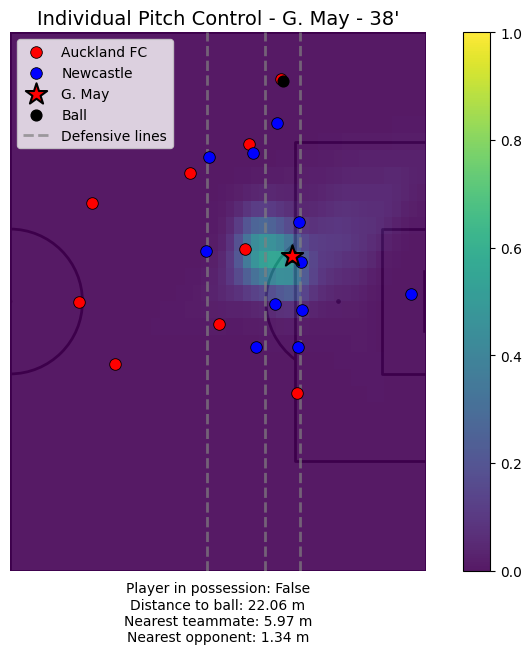

In [12]:
plot_half_pitch_individual_pitch_control(
    df=df_processed,
    frame_results=results[0]
)

In [8]:
# RUN ON ALL MATCHES AND SAVE OUTPUTS

process_all_matches_parallel(
    player_position=player_position,
    game_situation=game_situation,
    pitch_control_resolution= 1,
    max_workers= 10,
)

10 matches detected
 File already exists for match 2011166
 File already exists for match 1996435
 File already exists for match 2015213
 File already exists for match 2013725 File already exists for match 1899585
 File already exists for match 1953632

 File already exists for match 1886347
 File already exists for match 2006229
 File already exists for match 1925299
 File already exists for match 2017461


# IDENTIFY SPACE CLUSTERS

In [23]:
# RUN ON A SINGLE MATCH

meta = prepare_meta_df_single_match(
    results= results,
    processed_df= df_processed,
    match_id= 1886347,
    game_situation_name= game_situation[1]
)

NameError: name 'results' is not defined

In [5]:
# RUN ON ALL MATCHES AND SAVE OUTPUTS

X, meta, frames_inputs = prepare_clustering_features_all_matches(
    player_position=player_position,
    game_situation=game_situation
)

100%|██████████| 10/10 [00:23<00:00,  2.36s/it]


In [8]:
meta_clusters = predict_clusters(
    player_position=player_position, 
    game_situation=game_situation, 
    X=X, 
    meta=meta, 
    local=False
)

In [13]:
meta_clusters.head()

,match_id,frame,player_id,player_position_role,player_name,player_team,opponent_team,minute,game_situation,cluster,cluster_gathered
0,1886347,301,38673,Center Forward,G. May,Auckland FC,Newcastle United Jets FC,0,low_block,1,1
1,1886347,350,38673,Center Forward,G. May,Auckland FC,Newcastle United Jets FC,0,low_block,0,0
2,1886347,1102,966120,Center Forward,B. Gibson,Newcastle United Jets FC,Auckland FC,1,low_block,0,0
3,1886347,1122,966120,Center Forward,B. Gibson,Newcastle United Jets FC,Auckland FC,1,low_block,3,1
4,1886347,1204,966120,Center Forward,B. Gibson,Newcastle United Jets FC,Auckland FC,1,low_block,1,1


In [14]:
meta_clusters.player_position_role.iloc[0]

'Center Forward'

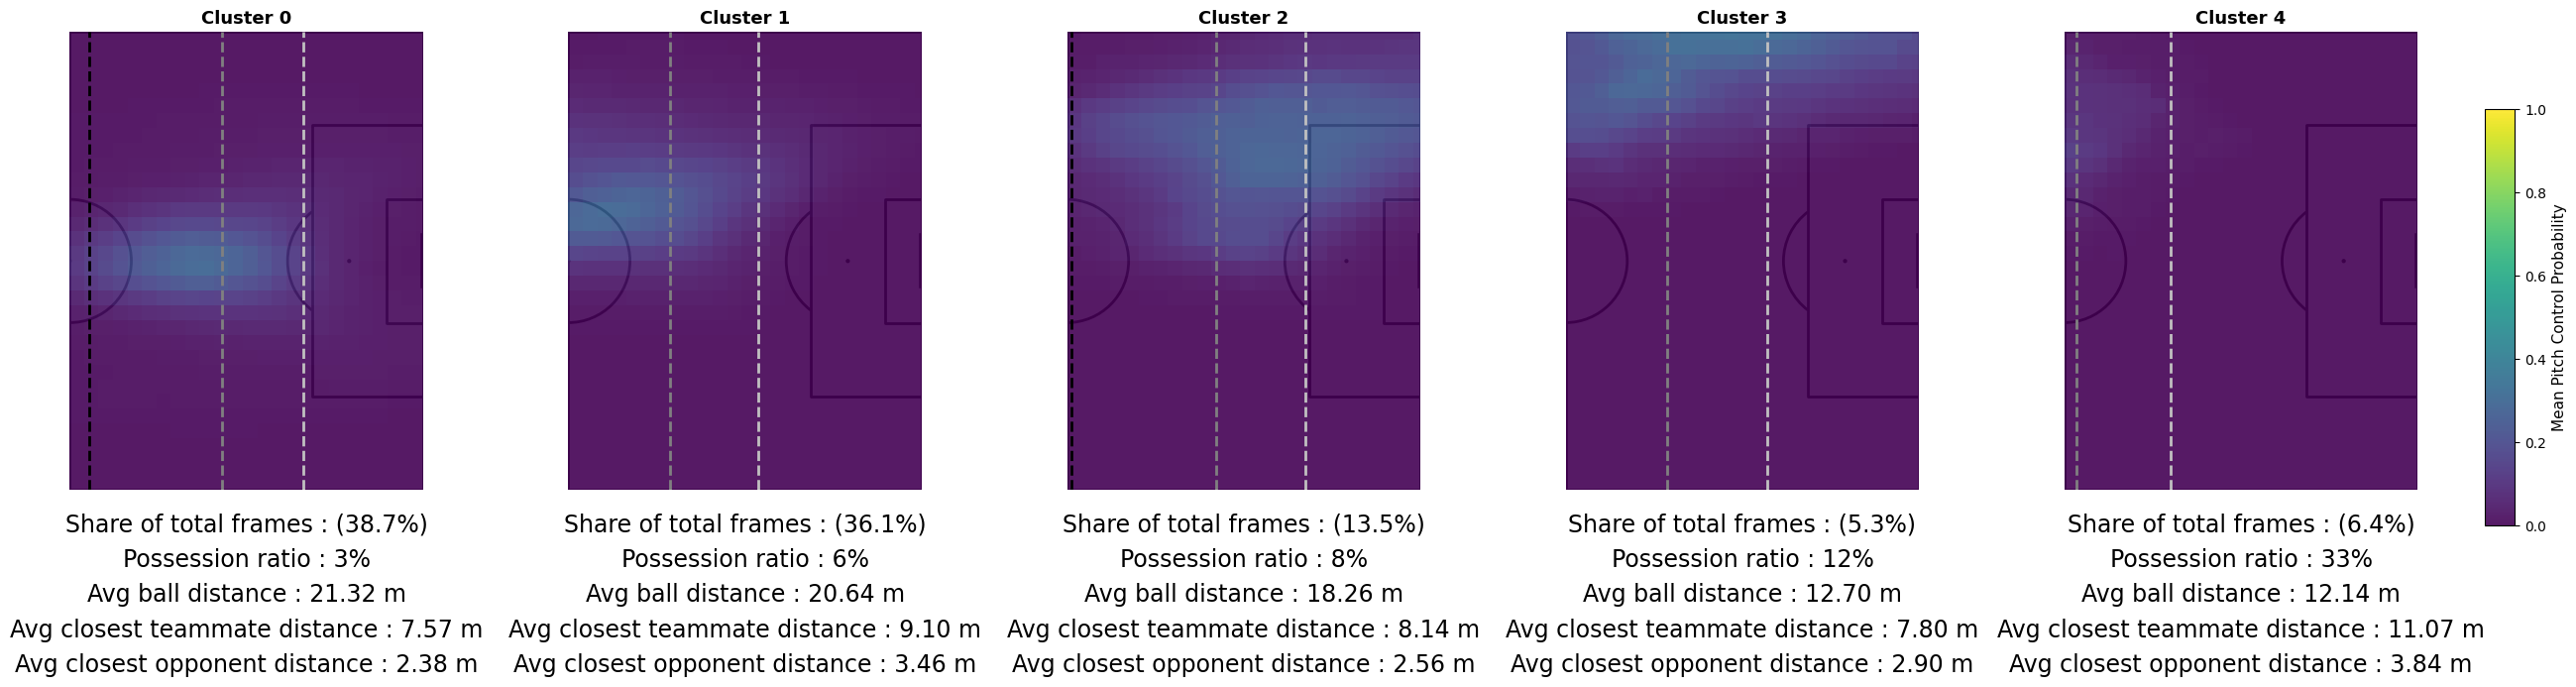

In [18]:
plot_cluster_summary_pitch_control(
    results=frames_inputs,
    meta=meta_clusters
)

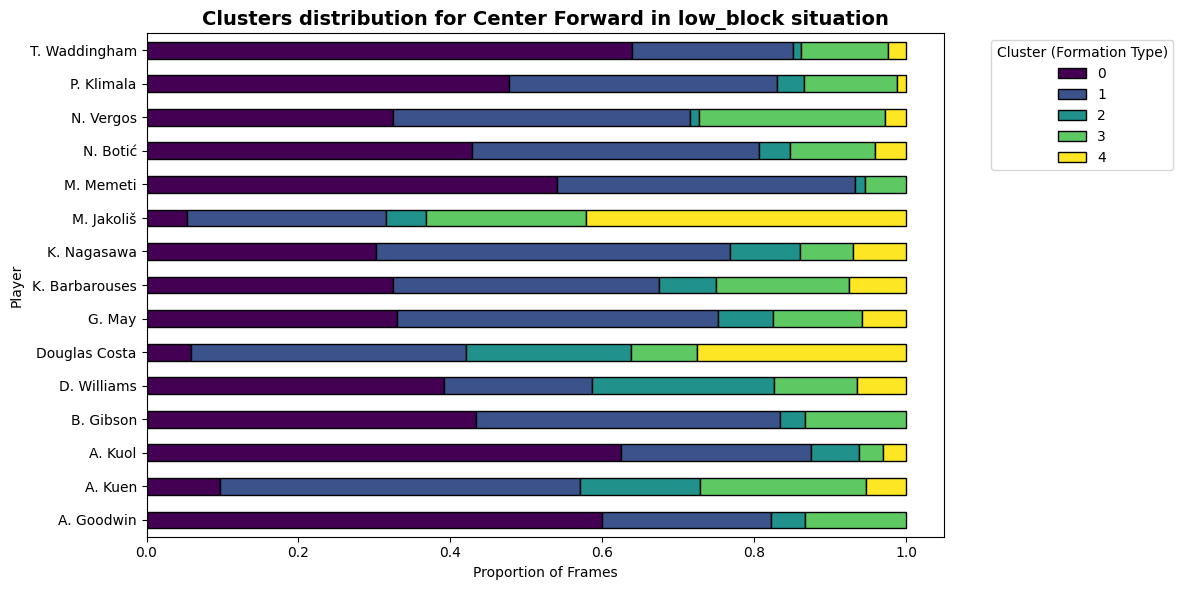

In [16]:
plot_players_cluster_distribution(
    meta=meta_clusters
)